In [1]:

import os
import utils
import dotenv
import umap
import pandas as pd
import scipy.stats as stats
import numpy as np
import dataextraction as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, Birch
import hdbscan
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns

d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\umap\d

## Loading and Preprocessing Data
Before moving onto the clustering, we need to load the data and preprocess it. The data is loaded from the file `finalrefined.csv` by importing OS for obtaining root path of the project and referencing `finalrefined.csv` in the data folder. 

In [2]:
dotenv.load_dotenv()

True

In [3]:
df = pd.read_csv(f'{os.getenv("ROOT_DIR")}\\data\\finalrefined.csv')
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,False,True,False,False,False,True,False,False
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,False,True,False,False,False
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,False,True,False,False
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,False,True,False
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,False,True,False,False
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,False,True,False,False
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,False,True,False
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,False,True,False,False,False,True,False,False


Mapping mortality rates with the function `aggregate_score_to_mortality()` from the utils module for mapping LODS scores of the patients with the related logit functions, these mortality rates will be further used for mapping patients to ICU levels 

In [4]:

df_subject_mr = utils.aggregate_score_to_mortality()
df_subject_mr

Connected to the PostgreSQL database
PostgreSQL version: PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit


,subject_id,mr_lods
0,25225,0.104107
1,15574,0.048017
2,52619,0.048017
3,85940,0.048017
4,12411,0.288948
...,...,...
61046,3793,0.149936
61047,11099,0.288948
61048,93831,0.071114
61049,50334,0.104107


Mergeing mortality rates with the base dataset for matching with the aggregateunqiue patient records, ad and one-hot encoded features and further avoiding duplicate patient records since the df_subject_mr includes duplicated subject records for mapped mortality rates

In [5]:
df = df.merge(df_subject_mr.drop_duplicates(subset='subject_id'), on='subject_id', how='left')
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,mr_lods
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,True,False,False,False,True,False,False,0.683240
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,True,False,False,False,0.149936
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,True,False,False,0.483531
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,True,False,0.288948
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,True,False,False,0.104107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,True,False,False,0.149936
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,True,False,False,0.149936
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,True,False,0.483531
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,True,False,False,False,True,False,False,0.104107


Finally applying `map_mortality_rate_to_icu_level` for obtaining related ICU levels to the patients, we simply divided mortality rates to number of ICU levels (3 in this case) from 0.0 (mild) to 1 (critical)

In [6]:
df['icu_level'] = df['mr_lods'].apply(utils.map_mortality_rate_to_icu_level)
df['icu_level']

0        Level 3
1        Level 1
2        Level 2
3        Level 1
4        Level 1
          ...   
10188    Level 1
10189    Level 1
10190    Level 2
10191    Level 1
10192    Level 1
Name: icu_level, Length: 10193, dtype: object

In [7]:
df["icu_level"].describe()

count       10193
unique          3
top       Level 1
freq         7807
Name: icu_level, dtype: object

Removing unecessary columns such as ID's mortality rates since we are only interested in ICU levels and not removing mortality rates could lead to data leakage.

In [8]:

columns_to_remove = ["subject_id", "hadm_id", "icustay_id", "mr_lods"]
df = df.drop(columns_to_remove, axis=1)

Lable encoding the ICU levels for further since some of the clustering models don't accept string values 

In [9]:
label_encoder = LabelEncoder()
df["icu_level"] = label_encoder.fit_transform(df["icu_level"])
df["icu_level"]

0        2
1        0
2        1
3        0
4        0
        ..
10188    0
10189    0
10190    1
10191    0
10192    0
Name: icu_level, Length: 10193, dtype: int32

## Clustering and Dimensionality Reduction
For further operation on the dataset we first reduce the dimension of the data. Data has a high number of features (high-dimensional), dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) can be used to reduce the dimensionality. High-dimensional data can suffer from the "curse of dimensionality," leading to increased computational complexity and decreased clustering performance. Reducing dimensionality can help address these issues and improve clustering results. By reducing the dimensionality, you might retain the most important information while discarding noise or irrelevant features, which can lead to more meaningful clustering results.

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [11]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(scaled_data)

In [12]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

In [13]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_result)

Visualizing the reduced dimensions of the dataset

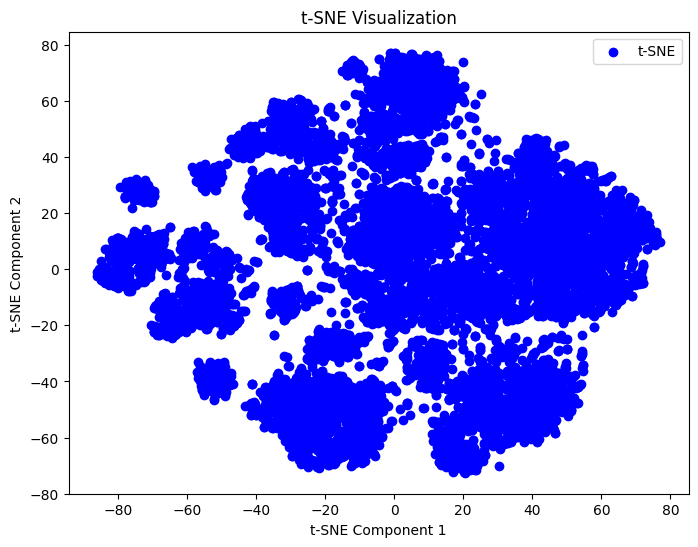

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='b', marker='o', label='t-SNE')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

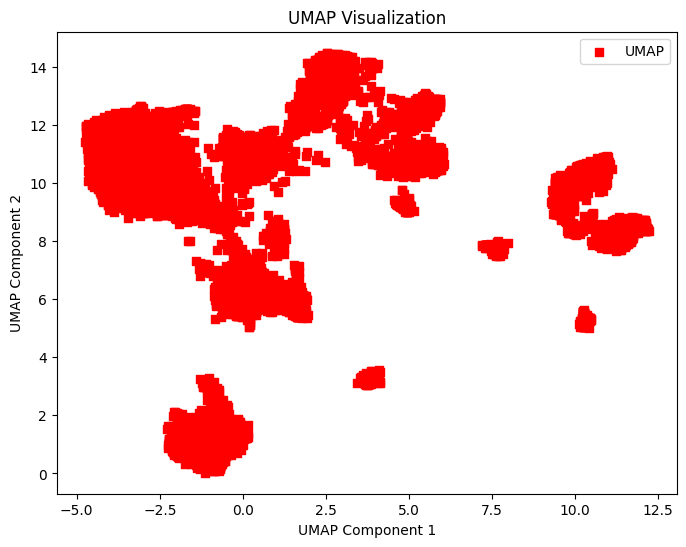

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='r', marker='s', label='UMAP')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

Running clustering algorithms on the dimensionality reduced data 

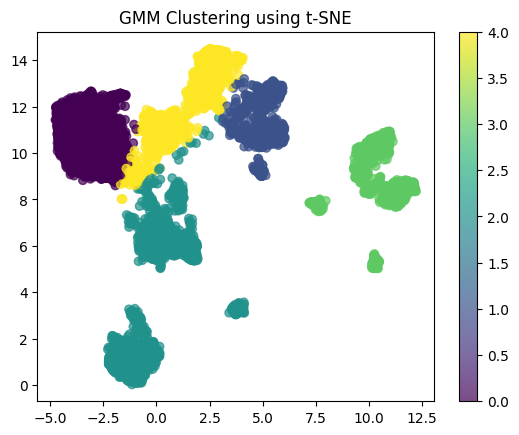

In [16]:
n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(umap_result)

df['GMM_Cluster_UMAP'] = gmm_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('GMM Clustering using t-SNE')
plt.show()

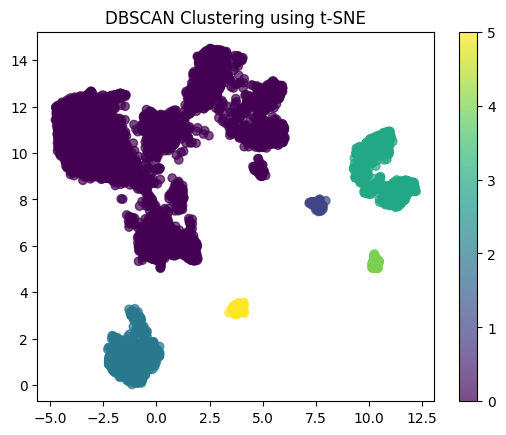

In [17]:
eps = 0.8
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(umap_result)

df['DBSCAN_Cluster_UMAP'] = dbscan_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('DBSCAN Clustering using t-SNE')
plt.show()

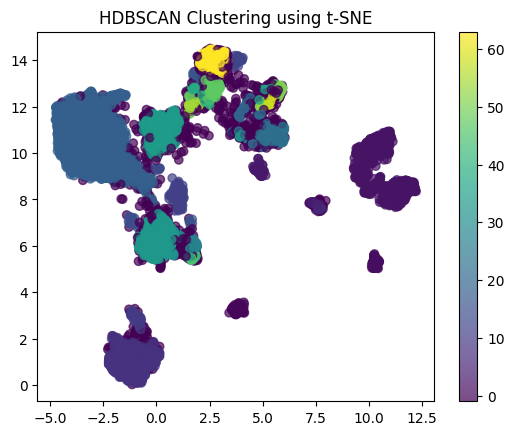

In [18]:
min_cluster_size = 5

hdb = hdbscan.HDBSCAN(min_samples=min_cluster_size)
hdb_labels = hdb.fit_predict(umap_result)

df['HDBSCAN_Cluster_UMAP'] = hdb_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('HDBSCAN Clustering using t-SNE')
plt.show()

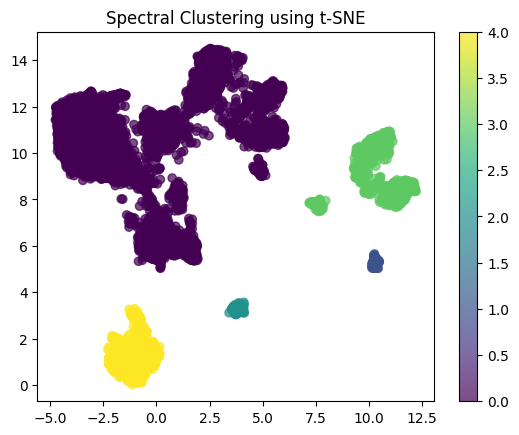

In [19]:
n_clusters = 5

spectral_clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', random_state=42)
spectral_labels = spectral_clustering.fit_predict(umap_result)

df['Spectral_Cluster_UMAP'] = spectral_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Spectral Clustering using t-SNE')
plt.show()

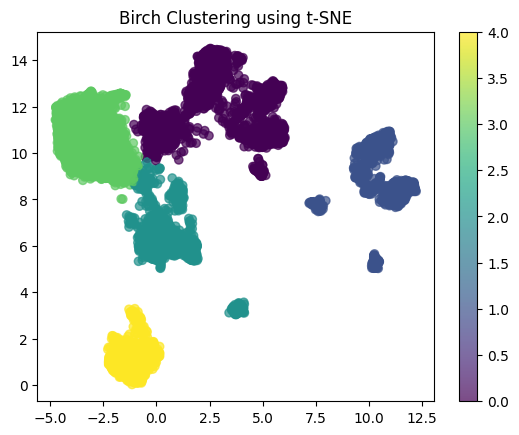

In [20]:
n_clusters = 5

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(umap_result)

# df['Birch_Cluster_UMAP'] = birch_labels

# Plotting the Birch clusters in 2D (assuming tsne_result, you can use umap_result as well)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=birch_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Birch Clustering using t-SNE')
plt.show()

d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


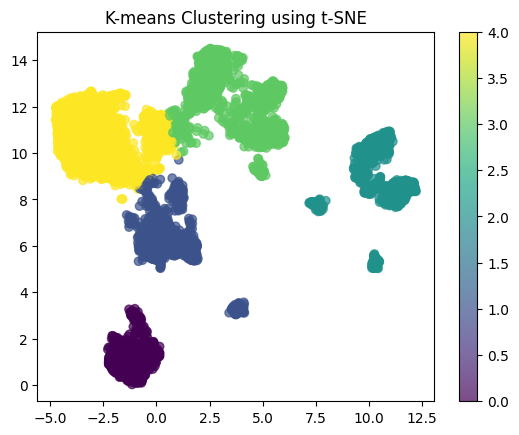

In [21]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_result)

# df['KMeans_Cluster_UMAP'] = kmeans_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('K-means Clustering using t-SNE')
plt.show()

## Cluster Analysis
Further we analyzed each clusters characteristics, how ICU level is scattered around on the clusters, how other features are scatter and affected the clustering and so on

In [23]:
# num_clusters = len(average_mortality)
# colors = ['grey'] * num_clusters

# colors[2] = 'blue'
# colors[4] = 'red'

# plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[colors[label] for label in df["KMeans_Cluster"]], alpha=0.7)

# plt.colorbar()
# plt.title('KMeans Clustering using t-SNE')
# plt.show()

In [24]:
# average_mortality = df.groupby('KMeans_Cluster')['mr_lods'].mean()

# print("Average Mortality Rate for Each Cluster:")
# print(average_mortality)

In [25]:
# median_mortality = df.groupby('Birch_Cluster')['mr_lods'].median()

# print("Median Mortality Rate for Each Cluster:")
# print(median_mortality)

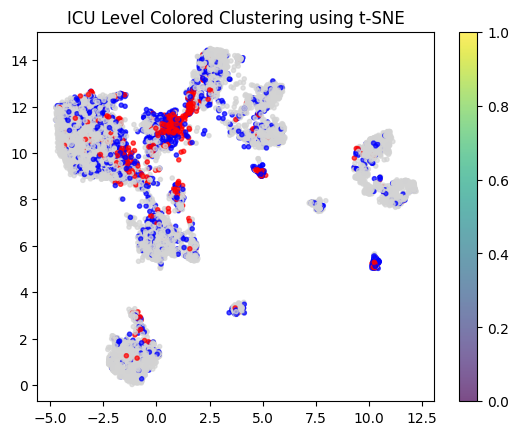

In [26]:
icu_level_colors = {
    0: 'lightgrey',
    1: 'blue',
    2: 'red'
}

colors_by_icu_level = [icu_level_colors[level] for level in df['icu_level']]

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors_by_icu_level, marker='.', alpha=0.7)

plt.colorbar()
plt.title('ICU Level Colored Clustering using t-SNE')
plt.show()

In [27]:
# Groupping by GMM clusters for further individual statistical analysis on each cluster and related
# features
df['GMM_Cluster_UMAP'] = gmm_labels
grouped_clusters = df.groupby('GMM_Cluster_UMAP')

In [28]:
cluster_means = grouped_clusters.mean()
cluster_means

,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,bicarbonate_mean,...,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,icu_level,DBSCAN_Cluster_UMAP,HDBSCAN_Cluster_UMAP,Spectral_Cluster_UMAP
GMM_Cluster_UMAP,,,,,,,,,,,,,,,,,,,,,
0,87.614145,118.221152,60.734606,77.488435,19.616101,36.831551,97.124207,140.544936,15.084579,23.389324,...,0.0,0.030769,0.126297,0.591413,0.239714,0.011807,0.255098,0.000000,17.884436,0.000000
1,84.276674,113.512057,57.047578,74.950978,17.460793,36.820480,97.884718,130.837563,12.041334,24.064575,...,0.0,0.023829,0.050945,0.593262,0.325390,0.006574,0.225965,0.000000,19.420707,0.000000
2,87.664919,122.546792,62.133061,80.545226,18.226667,37.013189,97.809115,140.995252,14.074707,23.346143,...,0.0,0.036959,0.096445,0.453010,0.387892,0.025695,0.206617,1.137276,16.463569,1.849349
3,84.227707,113.348215,57.740663,74.987650,17.215420,36.830082,97.886962,128.149718,11.606635,23.872892,...,0.0,0.017725,0.042836,0.534712,0.402511,0.002216,0.191285,2.905465,2.112999,2.819793
4,88.445945,112.368966,57.734863,74.702413,20.423910,36.773651,96.453698,150.611212,16.234838,22.287954,...,0.0,0.016616,0.056395,0.670191,0.251259,0.005539,0.630916,0.000000,36.375126,0.000000


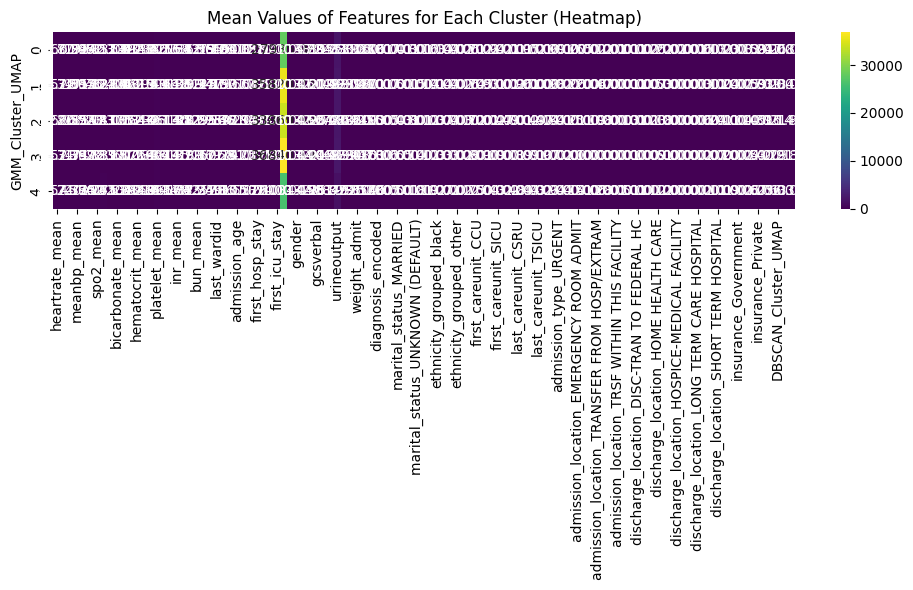

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap='viridis', annot=True, fmt='.2f')
plt.title('Mean Values of Features for Each Cluster (Heatmap)')
plt.tight_layout()
plt.show()

In [30]:
cluster_medians = grouped_clusters.median()
cluster_medians

,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,bicarbonate_mean,...,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,icu_level,DBSCAN_Cluster_UMAP,HDBSCAN_Cluster_UMAP,Spectral_Cluster_UMAP
GMM_Cluster_UMAP,,,,,,,,,,,,,,,,,,,,,
0,87.341521,115.776901,59.920000,75.990739,19.044048,36.777777,97.433333,132.500000,14.5,23.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.0,0.0
1,83.656250,112.516129,56.882353,74.422619,17.243243,36.812245,98.025000,126.846154,12.0,24.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,0.0
2,86.862069,121.214286,61.432650,79.815779,17.820020,36.984127,98.140909,135.636364,13.8,23.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
3,83.625000,112.131944,57.417949,74.393827,16.903536,36.831008,98.079497,124.639443,11.0,24.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0
4,86.911421,110.449730,56.922969,73.529457,19.901750,36.760764,97.200000,141.000000,15.5,22.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.0,0.0


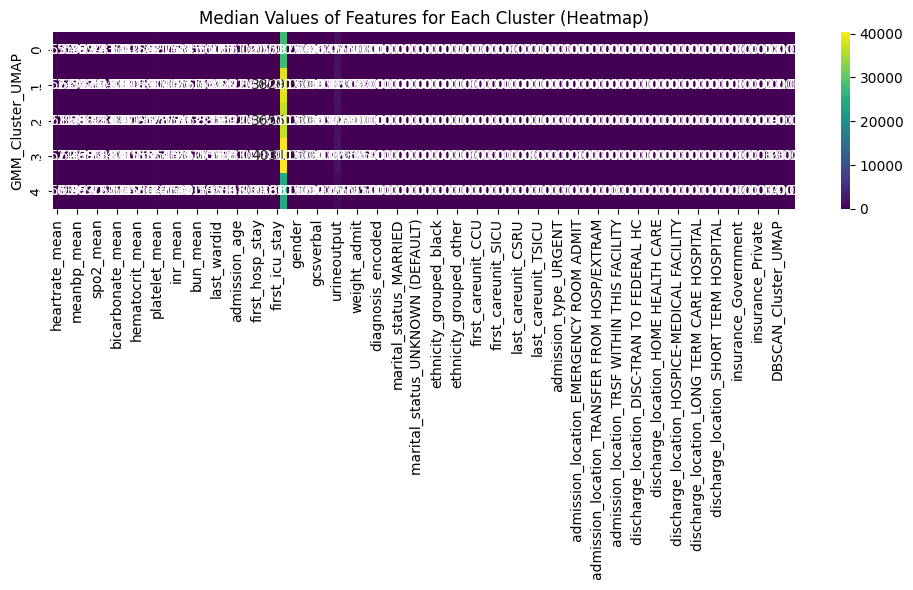

In [31]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_medians, cmap='viridis', annot=True, fmt='.2f')
plt.title('Median Values of Features for Each Cluster (Heatmap)')
plt.tight_layout()
plt.show()

In [32]:
# Get the explained variance ratio, which indicates the importance of each component
explained_variance_ratio = pca.explained_variance_ratio_

In [33]:
# Create a DataFrame to store the feature importances
pca_importance_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                 index=[f'PC{i+1}' for i in range(20)])

In [34]:
# Sort the DataFrame by the importance values in descending order
pca_importance_df = pca_importance_df.sort_values(by='Explained Variance Ratio', ascending=False)

In [35]:
# Print the feature importances
print("PCA Feature Importances:")
print(pca_importance_df)

PCA Feature Importances:
      Explained Variance Ratio
PC1                   0.066457
PC2                   0.049659
PC3                   0.044201
PC4                   0.033534
PC5                   0.029734
PC6                   0.027126
PC7                   0.025333
PC8                   0.022341
PC9                   0.022134
PC10                  0.020770
PC11                  0.019266
PC12                  0.017812
PC13                  0.017626
PC14                  0.016874
PC15                  0.015983
PC16                  0.015785
PC17                  0.014849
PC18                  0.014472
PC19                  0.013499
PC20                  0.012971


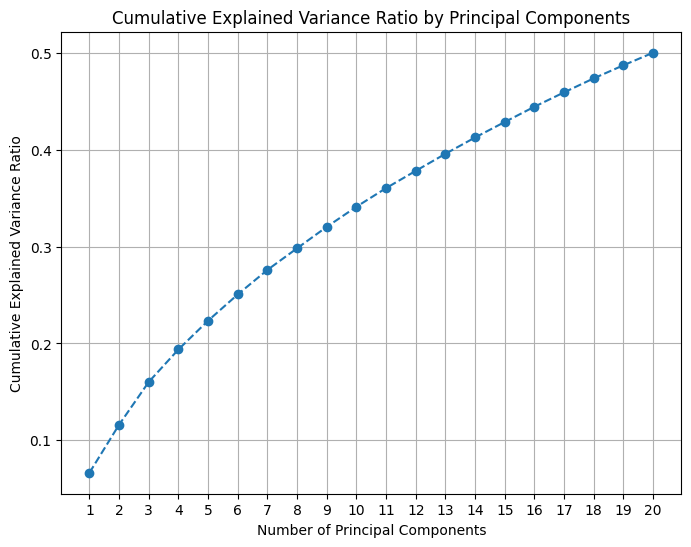

In [36]:
# Cumulative sum of explained variance ratio
cumulative_variance = pca_importance_df['Explained Variance Ratio'].cumsum()

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20 + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.xticks(range(1, 20 + 1))
plt.grid(True)
plt.show()

In [44]:
cluster_labels_list = [
    {
        "name": "KMeans",
        "labels": kmeans_labels        
    },
    {
        "name": "GMM",
        "labels": gmm_labels
    },
    {
        "name": "DBSCAN",
        "labels": dbscan_labels
    },
    {
        "name": "HDBSCAN",
        "labels": hdb_labels
    },
    {
        "name": "BIRCH",
        "labels": birch_labels
    },
    {
        "name": "Spectral Clustering",
        "labels": spectral_labels    
    }
]

for model in cluster_labels_list:    
    silhouette = silhouette_score(umap_result, model["labels"])
    davies_bouldin = davies_bouldin_score(umap_result, model["labels"])
    calinski_harabasz = calinski_harabasz_score(umap_result, model["labels"])
    print(f"Score for {model['name']}")
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print("---------------------------------------------")

Score for KMeans
Silhouette Score: 0.6032312512397766
Davies-Bouldin Index: 0.5247908736029568
Calinski-Harabasz Index: 23732.845530003142
---------------------------------------------
Score for GMM
Silhouette Score: 0.5185438394546509
Davies-Bouldin Index: 0.6714657526986156
Calinski-Harabasz Index: 15917.1187739992
---------------------------------------------
Score for DBSCAN
Silhouette Score: 0.3862735331058502
Davies-Bouldin Index: 0.44832440438062204
Calinski-Harabasz Index: 4149.863672389184
---------------------------------------------
Score for HDBSCAN
Silhouette Score: 0.24583908915519714
Davies-Bouldin Index: 1.2289239406999408
Calinski-Harabasz Index: 2243.214731410877
---------------------------------------------
Score for BIRCH
Silhouette Score: 0.5898960828781128
Davies-Bouldin Index: 0.558025171551563
Calinski-Harabasz Index: 21960.87717534375
---------------------------------------------
Score for Spectral Clustering
Silhouette Score: 0.4201686680316925
Davies-Bouldin 

In [45]:
df

,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,bicarbonate_mean,...,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,icu_level,GMM_Cluster_UMAP,DBSCAN_Cluster_UMAP,HDBSCAN_Cluster_UMAP,Spectral_Cluster_UMAP
0,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,18.00,...,False,False,True,False,False,2,0,0,18,0
1,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,28.00,...,False,True,False,False,False,0,4,0,34,0
2,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,20.25,...,False,False,True,False,False,1,4,0,34,0
3,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,22.50,...,False,False,False,True,False,0,4,0,63,0
4,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,25.50,...,False,False,True,False,False,0,4,0,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,20.50,...,False,False,True,False,False,0,1,0,19,0
10189,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,21.50,...,False,False,True,False,False,0,3,3,2,3
10190,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,19.75,...,False,False,False,True,False,1,0,0,18,0
10191,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,22.50,...,False,False,True,False,False,0,4,0,63,0


In [46]:
# Saving dataset for use in eda later on
df.to_csv(f'{os.getenv("ROOT_DIR")}\\data\\finalrefinedclustered.csv', index=False)